In [1]:
# check the env path

import sys
print(sys.executable)

d:\github\venvs\mlflow\scripts\python.exe


In [2]:
# what's the python version
!python --version

Python 3.9.6


In [3]:
# do the imports

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

import mlflow

In [4]:
# create a class for pre-processing

class Preprocessor():
    
    @staticmethod
    def load_data(path):
        data = pd.read_csv(path)
        return data

    
    @staticmethod
    def data_cleaning(data):
        print("na values available in data \n")
        print(data.isna().sum())
        data = data.dropna()
        print("after droping na values \n")
        print(data.isna().sum())
        return data
    
    
    @staticmethod
    def preprocessing(data):
        data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
        data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
        data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

        cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
        for var in cat_vars:
            cat_list='var'+'_'+var
            cat_list = pd.get_dummies(data[var], prefix=var)
            data1=data.join(cat_list)
            data=data1

        cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
        data_vars=data.columns.values.tolist()
        to_keep=[i for i in data_vars if i not in cat_vars]

        final_data=data[to_keep]

        final_data.columns = final_data.columns.str.replace('.','_')
        final_data.columns = final_data.columns.str.replace(' ','_')
        return final_data
    
    
    @staticmethod
    def train_test_split(final_data):
        X = final_data.loc[:, final_data.columns != 'y']
        y = final_data.loc[:, final_data.columns == 'y']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify = y, random_state=47)
        return X_train, X_test, y_train, y_test
    
    
    @staticmethod
    def over_sampling_target_class(X_train, y_train):
        
        os = SMOTE(random_state=0)

        columns = X_train.columns
        os_data_X,os_data_y=os.fit_resample(X_train, y_train)

        os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
        os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
        # we can Check the numbers of our data
        print("length of oversampled data is ",len(os_data_X))
        print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
        print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
        print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
        print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

        X_train = os_data_X
        y_train = os_data_y['y']

        return X_train, y_train

In [5]:
class Engine():
    
    @staticmethod
    def training_basic_classifier(X_train,y_train):
        model = RandomForestClassifier(n_estimators=101)
        model.fit(X_train, y_train)
        return model

    @staticmethod
    def predict_on_test_data(model,X_test):
        y_pred = model.predict(X_test)
        return y_pred
    
    @staticmethod
    def predict_prob_on_test_data(model,X_test):
        y_pred = model.predict_proba(X_test)
        return y_pred
    
    @staticmethod
    def get_metrics(y_true, y_pred, y_pred_prob):
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        entropy = log_loss(y_true, y_pred_prob)
        return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}  
    
    @staticmethod
    def create_roc_auc_plot(clf, X_data, y_data):
        metrics.plot_roc_curve(clf, X_data, y_data) 
        plt.savefig('roc_auc_curve.png')
        
    @staticmethod
    def create_confusion_matrix_plot(clf, X_test, y_test):
        plot_confusion_matrix(clf, X_test, y_test)
        plt.savefig('confusion_matrix.png')
        
    @staticmethod
    def hyper_parameter_tuning(X_train, y_train):
        # define random parameters grid
        n_estimators = [5,21,51,101] # number of trees in the random forest
        max_features = ['auto', 'sqrt'] # number of features in consideration at every split
        max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
        min_samples_split = [2, 6, 10] # minimum sample number to split a node
        min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
        bootstrap = [True, False] # method used to sample data points

        random_grid = {'n_estimators': n_estimators,
                        'max_features': max_features,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf,
                        'bootstrap': bootstrap
                      }

        classifier = RandomForestClassifier()
        model_tuning = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid,
                       n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
        model_tuning.fit(X_train, y_train)

        print ('Random grid: ', random_grid, '\n')
        # print the best parameters
        print ('Best Parameters: ', model_tuning.best_params_, ' \n')

        best_params = model_tuning.best_params_

        n_estimators = best_params['n_estimators']
        min_samples_split = best_params['min_samples_split']
        min_samples_leaf = best_params['min_samples_leaf']
        max_features = best_params['max_features']
        max_depth = best_params['max_depth']
        bootstrap = best_params['bootstrap']

        model_tuned = RandomForestClassifier(n_estimators = n_estimators, min_samples_split = min_samples_split,
                                             min_samples_leaf= min_samples_leaf, max_features = max_features,
                                             max_depth= max_depth, bootstrap=bootstrap) 
        model_tuned.fit( X_train, y_train)
        return model_tuned,best_params

In [6]:
data = Preprocessor.load_data("./data.csv")
cleaned_data = Preprocessor.data_cleaning(data)

na values available in data 

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
after droping na values 

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64


In [7]:
final_data = Preprocessor.preprocessing(cleaned_data)

C:\Users\laksh\AppData\Local\Temp\ipykernel_5884\523771657.py:40: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  final_data.columns = final_data.columns.str.replace('.','_')


In [8]:
X_train, X_test, y_train, y_test = Preprocessor.train_test_split(final_data)

In [9]:
X_train, y_train = Preprocessor.over_sampling_target_class(X_train, y_train)

length of oversampled data is  51166
Number of no subscription in oversampled data 25583
Number of subscription 25583
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [10]:
model = Engine.training_basic_classifier(X_train,y_train)

In [14]:
y_pred = Engine.predict_on_test_data(model,X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [15]:
y_pred_prob = Engine.predict_prob_on_test_data(model,X_test) #model.predict_proba(X_test)
y_pred_prob

array([[0.99009901, 0.00990099],
       [0.97029703, 0.02970297],
       [0.94059406, 0.05940594],
       ...,
       [1.        , 0.        ],
       [0.63366337, 0.36633663],
       [1.        , 0.        ]])

In [16]:
run_metrics = Engine.get_metrics(y_test, y_pred, y_pred_prob)
run_metrics

{'accuracy': 0.91, 'precision': 0.63, 'recall': 0.52, 'entropy': 0.2}

d:\github\venvs\mlflow\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


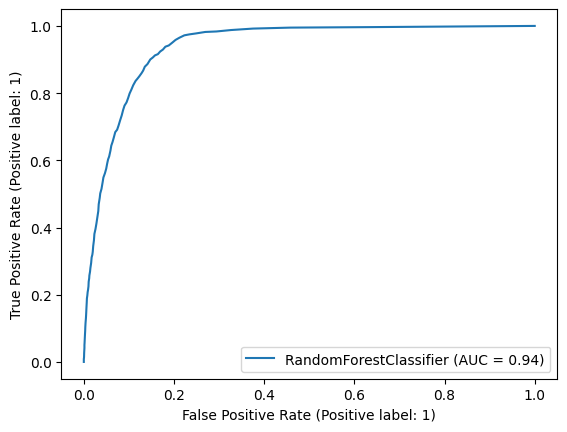

In [17]:
Engine.create_roc_auc_plot(model, X_test, y_test)

d:\github\venvs\mlflow\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


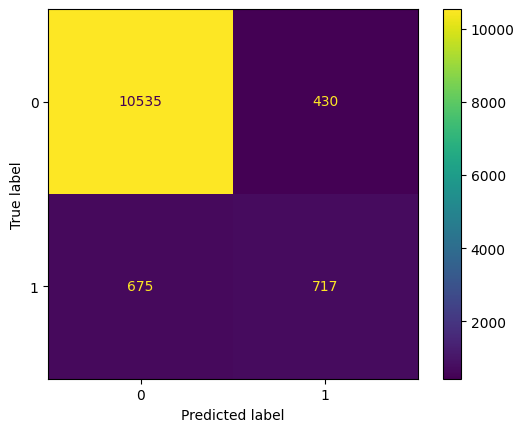

In [18]:
Engine.create_confusion_matrix_plot(model, X_test, y_test)

In [19]:
#mlflow

experiment_name = "basic_classifier"
run_name = "term_deposit"
run_metrics = Engine.get_metrics(y_test, y_pred, y_pred_prob)
print(run_metrics)

{'accuracy': 0.91, 'precision': 0.63, 'recall': 0.52, 'entropy': 0.2}


In [21]:
def create_experiment(experiment_name,run_name, run_metrics,model, confusion_matrix_path = None, 
                      roc_auc_plot_path = None, run_params=None):

    #     mlflow.set_tracking_uri('http://localhost:5000') # when using sql as a database
''' 
Without this, all the experiments and artifacts are stored in the file registry. With this command
the data is stored in the database, but we need to configure the database (see further sections).
'''
    mlflow.set_experiment(experiment_name) 

    with mlflow.start_run():
        
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
            
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
        
        mlflow.sklearn.log_model(model, "model")
        
        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, 'confusion_materix')
            
        if not roc_auc_plot_path == None:
            mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")
        
        mlflow.set_tag("tag1", "Random Forest")
        mlflow.set_tags({"tag2":"Randomized Search CV", "tag3":"Production"})
            
    print('Run - %s is logged to Experiment - %s' %(run_name, experiment_name))

In [22]:
create_experiment(experiment_name,run_name,run_metrics,model,'confusion_matrix.png', 'roc_auc_curve.png')

2022/10/19 21:51:30 INFO mlflow.tracking.fluent: Experiment with name 'basic_classifier' does not exist. Creating a new experiment.


Run - term_deposit is logged to Experiment - basic_classifier


In [ ]:
# Create another experiment after tuning hyperparameters and log the best set of parameters for 
# which model gives the optimal performance

import mlflow
experiment_name = "optimized model"
run_name="Random_Search_CV_Tuned_Model"
model_tuned,best_params = Engine.hyper_parameter_tuning(X_train, y_train)
run_params = best_params

y_pred = Engine.predict_on_test_data(model_tuned,X_test) #will return the predicted class
y_pred_prob = Engine.predict_prob_on_test_data(model_tuned,X_test) #model.predict_proba(X_test)
run_metrics = Engine.get_metrics(y_test, y_pred, y_pred_prob)

In [25]:
run_metrics

{'accuracy': 0.91, 'precision': 0.63, 'recall': 0.52, 'entropy': 0.2}

In [26]:
for param in run_params:
    print(param, run_params[param])

n_estimators 101
min_samples_split 6
min_samples_leaf 3
max_features sqrt
max_depth 50
bootstrap True


In [27]:
create_experiment(experiment_name,run_name,run_metrics,model_tuned,'confusion_matrix.png', 'roc_auc_curve.png',run_params)

2022/10/19 21:55:34 INFO mlflow.tracking.fluent: Experiment with name 'optimized model' does not exist. Creating a new experiment.


Run - Random_Search_CV_Tuned_Model is logged to Experiment - optimized model


To use model registry, database is required. Instead of running the UI directly, the tracking API uses sqlite as a backend storage.


In [1]:
!pip install pysqlite3

Using legacy 'setup.py install' for pysqlite3, since package 'wheel' is not installed.
    Running setup.py install for pysqlite3: started
    Running setup.py install for pysqlite3: finished with status 'done'


You should consider upgrading via the 'd:\github\venvs\mlflow\scripts\python.exe -m pip install --upgrade pip' command.


# MySQL

`CREATE DATABASE mlflow_tracking_database;`

- Start MLflow tracking server using MySQL as a backend tracking store.

`mlflow server \ --backend-store-uri  mysql+pymysql://root@localhost/mlflow_tracking_database \ --default-artifact-root  file:/./mlruns \ -h 0.0.0.0 -p 5000`

- Set the MLflow tracking uri (within code section)

`mlflow.set_tracking_uri("http://localhost:5000")`

# sqlite

- Start MLflow tracking server using sqlite as a backend tracking store

`mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts --host 0.0.0.0 --port 5000

`- Set the MLflow tracking uri (within code section)

`mlflow.set_tracking_uri("http://localhost:5000")`

- You can also follow the official documentation for more information on backend database for model registry

https://www.mlflow.org/docs/latest/model-registry.html#model-registry-workflows